# Adding the ability to find interfaces using measurePPI.py
2025-02-05

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import numpy as np
import time
import re
from matplotlib.axes._axes import Axes as matplotlib_Axis

In [2]:
AF_prediction_path = Path("../ressources/AF_predictions").resolve()
AF_prediction_results = Path("../ressources/AF_predictions/AF_prediction_randomized_DMI_results.xlsx").resolve()
AF_prediction_metrics = Path("../ressources/AF_predictions/AF_metrics_all_structures.tsv").resolve()
AF_DMI_structures_folders = [Path("../ressources/AF_DMI_structures").resolve() / p for p in ['AF_DMI_structures1', 'AF_DMI_structures2', 'AF_DMI_structures3', "AF_DMI_mutated_structures"]]
AF_DDI_structures_path = Path("../ressources/AF_DDI_structures").resolve()
solved_DMI_structures_path = Path("../ressources/DMI_solved_structures_hydrogens").resolve()
solved_DDI_structures_path = Path("../ressources/DDI_solved_structures_hydrogens").resolve()

for p in [AF_prediction_results, AF_prediction_metrics, AF_DDI_structures_path, solved_DMI_structures_path, solved_DDI_structures_path] + AF_DMI_structures_folders:
    if not p.exists():
        print(f"{p} does not point to a valid path")

In [4]:
libpath = Path("../src").resolve()
print(libpath)
sys.path.insert(0, str(libpath))
import measure_PPI
from measure_PPI import *

D:\Eigene Datein\Programmieren\Git\abrilka\bachelorthesis\src


In [5]:
#Loading sample structure
sampleStructure_name = "LIG_NRP_CendR_1_2ORZ"
sampleStructure_path = AF_DMI_structures_folders[1] / sampleStructure_name / "ranked_0.pdb"
#sampleStructure_name = "DEG_MDM2_SWIB_1_1YCR"
#sampleStructure_path = structure_folders[0] / sampleStructure_name / "ranked_1.pdb"
#sampleStructure_name = "DEG_Kelch_Keap1_1_2FLU"
#sampleStructure_path = structure_folders[0] / sampleStructure_name / "ranked_4.pdb"
pdb_id = sampleStructure_name.split("_")[-1]

structure_biopy, atomarray_biotite = OpenStructure(sampleStructure_path, sampleStructure_name)
print("AF", EvaluateStructure(sampleStructure_path, sampleStructure_name))

AF {'structure_name': 'LIG_NRP_CendR_1_2ORZ', 'file': 'ranked_0.pdb', 'hbonds': 5, 'salt_bridges': 2, 'buried_area': 698.607, 'min_distance': 6.297, 'hydrophobic_interactions': 0}


In [9]:
from sklearn.metrics import pairwise_distances
from Bio.PDB.Atom import Atom as BioPy_Atom

class ProteinStructureWarning(Exception):
    def __init__(self, message):            
        super().__init__(message)

def get_distance_matrix(structure_biopy:BioPy_PDBStructure) -> tuple[np.ndarray, list[BioPy_Atom], list[BioPy_Atom]]:
    stopwatch = Stopwatch().Start()
    chains = [c for c in structure_biopy.get_chains()]
    if not len(chains) == 2: raise ProteinStructureWarning(f"The protein needs to have 2 chains but it has {len(chains)}")
    chain1 = structure_biopy[0][chains[0].id]
    chain2 = structure_biopy[0][chains[1].id]
    

    chain1_atoms = np.array([a for a in chain1.get_atoms()])
    chain2_atoms = np.array([a for a in chain2.get_atoms()])
    chain1_coords = [a.coord for a in chain1_atoms]
    chain2_coords = [a.coord for a in chain2_atoms]
    stopwatch.Lap("Parsing the chains and atom arrays")

    distance_matrix = pairwise_distances(chain1_coords,chain2_coords)
    stopwatch.Lap("Distance Matrix")

    return (distance_matrix, chain1_atoms, chain2_atoms)

def get_interface(distance_matrix: np.ndarray, chain1_atoms: list[BioPy_Atom], chain2_atoms: list[BioPy_Atom], cutoff=5.0):
    pair_dist = np.argwhere(distance_matrix <= cutoff) # List of matrix indices where distance is below cutoff
    intf1_atoms = set(chain1_atoms[pair_dist[:, 0]]) # Set of the chain1 atoms with an atom from chain2 closer than cutoff distance
    intf2_atoms = set(chain2_atoms[pair_dist[:, 1]])

    # List of backbone atoms in the interface
    intf1_backbone = [a for a in intf1_atoms if a.name == "CA" and a in intf1_atoms]
    intf2_backbone = [a for a in intf2_atoms if a.name == "CA" and a in intf2_atoms]

    intf1_residues = [a.parent for a in intf1_backbone]
    intf2_residues = [a.parent for a in intf2_backbone]

    # A list for each chain combined to a tuple with the indices of the interface residues. Example : ([23, 445, 470], [26]) 
    backbone_indices_tuple = ([i for i,a in enumerate(chain1_atoms) if a in intf1_backbone], [i for i,a in enumerate(chain2_atoms) if a in intf2_backbone]) 

    # The distance matrix sliced to only the interface backbone atoms. So shape is (len(intf1_backbone), len(intf2_backbone))
    local_dist_matrix = distance_matrix[backbone_indices_tuple[0], :][:, backbone_indices_tuple[1]]

    min_distance = round(np.min(local_dist_matrix), 3)

    return (intf1_residues, intf2_residues, min_distance)


In [ ]:
def EvaluateStructure(path: pathlib.Path, structure_name: str = "") -> tuple[dict|None, measure_PPI.Stopwatch] :
    """
        Measures the pdb file given by path
    """
    stopwatch = Stopwatch().Start()
    file_name = path.name
    structure_biopy, atomarray_biotite = OpenStructure(path, structure_name)
    stopwatch.Lap("Loading structure")
    if structure_biopy is None or atomarray_biotite is None: return (None, stopwatch.Stop())

    buried_area = calculate_buried_area(structure_biopy) if measure_PPI._freesasa_ready else calculate_buried_area_biotite(atomarray_biotite)
    hbonds = calculate_hbonds(atomarray_biotite)
    min_distance = calculate_min_distance(atomarray_biotite)
    salt_bridges = calculate_saltbridges(structure_biopy)
    hydrophobic_interactions = calculate_hydrophobic_interactions(structure_biopy)

    return ({
        'structure_name': structure_name,
        'file': file_name,
        'hbonds': hbonds,
        'salt_bridges': salt_bridges,
        'buried_area': buried_area,
        'min_distance': min_distance,
        'hydrophobic_interactions': hydrophobic_interactions
    }, stopwatch.Stop())

result, stopwatch = EvaluateStructure(sampleStructure_path, sampleStructure_name)

print(stopwatch.times)



for k,v in Stopwatch.Evaluate([stopwatch]).items():
    logger.debug(f"Average time for {k}: {round(1000*(v[0]), 3)} ms (n = {v[1]})")

In [10]:
distance_matrix, chain1_atoms, chain2_atoms = get_distance_matrix(structure_biopy)
intf1_residues, intf2_residues, min_distance = get_interface(distance_matrix, chain1_atoms, chain2_atoms)

In [23]:
intf1_residues

[<Residue ILE het=  resseq=127 icode= >,
 <Residue GLY het=  resseq=126 icode= >,
 <Residue GLY het=  resseq=30 icode= >,
 <Residue SER het=  resseq=58 icode= >,
 <Residue GLU het=  resseq=31 icode= >,
 <Residue THR het=  resseq=28 icode= >,
 <Residue PRO het=  resseq=29 icode= >,
 <Residue ASP het=  resseq=32 icode= >,
 <Residue TYR het=  resseq=9 icode= >]

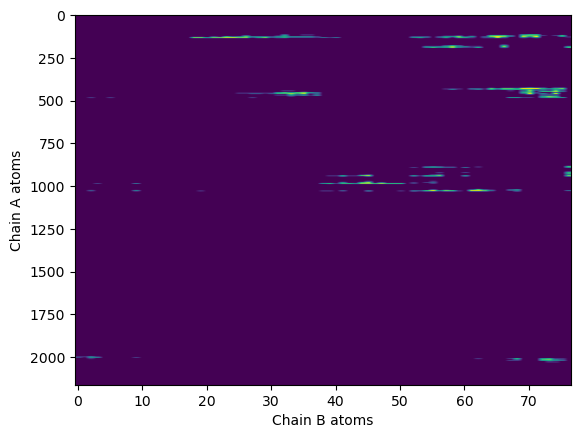

In [24]:
plt.imshow(distance_matrix <= 5, aspect="auto")
plt.ylabel("Chain A atoms")
plt.xlabel("Chain B atoms")
plt.show()

In [25]:
intf1_residues

[<Residue ILE het=  resseq=127 icode= >,
 <Residue GLY het=  resseq=126 icode= >,
 <Residue GLY het=  resseq=30 icode= >,
 <Residue SER het=  resseq=58 icode= >,
 <Residue GLU het=  resseq=31 icode= >,
 <Residue THR het=  resseq=28 icode= >,
 <Residue PRO het=  resseq=29 icode= >,
 <Residue ASP het=  resseq=32 icode= >,
 <Residue TYR het=  resseq=9 icode= >]

In [37]:
distance_matrix.shape

(2163, 77)

In [30]:
np.argwhere(distance_matrix <= 3)

array([[ 118,   71],
       [ 120,   69],
       [ 120,   70],
       [ 120,   71],
       [ 122,   71],
       [ 125,   32],
       [ 125,   71],
       [ 126,   32],
       [ 126,   71],
       [ 127,   59],
       [ 128,   59],
       [ 129,   26],
       [ 129,   32],
       [ 130,   23],
       [ 130,   26],
       [ 130,   28],
       [ 130,   29],
       [ 130,   32],
       [ 131,   23],
       [ 131,   24],
       [ 132,   24],
       [ 190,   76],
       [ 430,   66],
       [ 430,   69],
       [ 430,   75],
       [ 431,   69],
       [ 431,   70],
       [ 431,   72],
       [ 431,   74],
       [ 431,   75],
       [ 432,   64],
       [ 432,   66],
       [ 432,   67],
       [ 432,   68],
       [ 432,   75],
       [ 433,   66],
       [ 433,   69],
       [ 433,   70],
       [ 433,   71],
       [ 433,   75],
       [ 439,   70],
       [ 443,   69],
       [ 443,   70],
       [ 443,   74],
       [ 446,   74],
       [ 455,   35],
       [ 456,   31],
       [ 456,

In [44]:
pair_dist = np.argwhere(distance_matrix <= 3)
atom_pairs: list[tuple[BioPy_Atom, BioPy_Atom, float]] = [(chain1_atoms[ind[0]], chain2_atoms[ind[1]], distance_matrix[ind[0], ind[1]]) for ind in pair_dist]
atom_pairs

[(<Atom CB>, <Atom HH12>, 2.7150626),
 (<Atom HB3>, <Atom NH1>, 2.5802896),
 (<Atom HB3>, <Atom HH11>, 2.374427),
 (<Atom HB3>, <Atom HH12>, 2.1572723),
 (<Atom CG>, <Atom HH12>, 2.4285915),
 (<Atom CD2>, <Atom HE2>, 2.63707),
 (<Atom CD2>, <Atom HH12>, 2.6689527),
 (<Atom HD2>, <Atom HE2>, 2.081972),
 (<Atom HD2>, <Atom HH12>, 2.9333842),
 (<Atom CE1>, <Atom HB3>, 2.7225664),
 (<Atom HE1>, <Atom HB3>, 2.443064),
 (<Atom CE2>, <Atom HG2>, 2.8370283),
 (<Atom CE2>, <Atom HE2>, 2.8769948),
 (<Atom HE2>, <Atom HB3>, 2.853706),
 (<Atom HE2>, <Atom HG2>, 2.8262477),
 (<Atom HE2>, <Atom CD>, 2.76727),
 (<Atom HE2>, <Atom HD2>, 2.0818708),
 (<Atom HE2>, <Atom HE2>, 2.615802),
 (<Atom OH>, <Atom HB3>, 2.7045188),
 (<Atom OH>, <Atom O>, 2.8733425),
 (<Atom HH>, <Atom O>, 2.7103426),
 (<Atom HZ2>, <Atom OXT>, 2.6373847),
 (<Atom CG2>, <Atom HD3>, 2.7948043),
 (<Atom CG2>, <Atom NH1>, 2.9972963),
 (<Atom CG2>, <Atom CZ>, 2.9063158),
 (<Atom HG21>, <Atom NH1>, 2.998008),
 (<Atom HG21>, <Atom HH11>

In [40]:
type(atom_pairs[0][0])

Bio.PDB.Atom.Atom

In [45]:
intf1_residues

[<Residue ILE het=  resseq=127 icode= >,
 <Residue GLY het=  resseq=126 icode= >,
 <Residue GLY het=  resseq=30 icode= >,
 <Residue SER het=  resseq=58 icode= >,
 <Residue GLU het=  resseq=31 icode= >,
 <Residue THR het=  resseq=28 icode= >,
 <Residue PRO het=  resseq=29 icode= >,
 <Residue ASP het=  resseq=32 icode= >,
 <Residue TYR het=  resseq=9 icode= >]

In [47]:
set([a2.parent for a1, a2, d  in atom_pairs])

{<Residue LYS het=  resseq=2 icode= >,
 <Residue PRO het=  resseq=3 icode= >,
 <Residue ARG het=  resseq=4 icode= >}

In [ ]:
# Vector definition
# 0-5: amino acid properties
# 0: pK(R) acid constant of residue group or 7 if no residues

def atom_pairs_to_vector(atom1: BioPy_Atom, atom2: BioPy_Atom, distance: float) -> np.array:
    vector = np.full(shape=(10), fill_value=None)

    